In [ ]:
import pandas as pd

# synthea output.
csv_path = '../synthea/output/csv/'

patients = pd.read_csv(csv_path + 'patients.csv')
observations = pd.read_csv(csv_path + 'observations.csv')
conditions = pd.read_csv(csv_path + 'conditions.csv')
encounters = pd.read_csv(csv_path + 'encounters.csv')

observations['VALUE'] = pd.to_numeric(observations['VALUE'], errors='coerce')
observations.dropna(subset=['VALUE'], inplace=True)

print("Successfully loaded patient data from the synthea folder!")
print(patients.head())

Successfully loaded patient data from the synthea folder!
                                     Id   BIRTHDATE DEATHDATE          SSN  \
0  55cd7147-e6b7-d48e-a326-9cf81eced842  2001-04-29       NaN  999-80-1317   
1  e7d73efd-4cbf-79be-6e1d-5b978c3f46c5  1977-04-02       NaN  999-96-2742   
2  aa268a2f-ca37-03e9-04f6-7ca0b748e8de  1995-07-06       NaN  999-51-2290   
3  b138f3d7-5c60-0204-0d47-1c911ef1fa81  1999-01-25       NaN  999-24-6467   
4  ed9f640e-5ce5-2c36-8fbd-392b6e95dd0e  1974-02-26       NaN  999-22-7652   

     DRIVERS    PASSPORT PREFIX         FIRST       MIDDLE           LAST  \
0  S99991433  X58811353X    Ms.      Young120          NaN       Haley279   
1  S99935819  X64519464X   Mrs.      Colby655          NaN     Cummings51   
2  S99946841  X30573682X    Mr.      Leroy603       Chas63        Emard19   
3  S99993990  X12829528X    Ms.    Collene784  Latarsha812    Shanahan202   
4  S99918735  X13669618X   Mrs.  Katheleen349   Raylene798  Macejkovic424   

   ...    

In [ ]:
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
patients['DEATHDATE'] = pd.to_datetime(patients['DEATHDATE'], errors='coerce')

observations['DATE'] = pd.to_datetime(observations['DATE'])

conditions['START'] = pd.to_datetime(conditions['START'])
conditions['STOP'] = pd.to_datetime(conditions['STOP'])

encounters['START'] = pd.to_datetime(encounters['START'])
encounters['STOP'] = pd.to_datetime(encounters['STOP'])

observations['DATE'] = observations['DATE'].dt.tz_localize(None)
conditions['START'] = conditions['START'].dt.tz_localize(None)
conditions['STOP'] = conditions['STOP'].dt.tz_localize(None)
encounters['START'] = encounters['START'].dt.tz_localize(None)
encounters['STOP'] = encounters['STOP'].dt.tz_localize(None)

print("--- Observations Info After Date Conversion ---")
observations.info()

--- Observations Info After Date Conversion ---
<class 'pandas.core.frame.DataFrame'>
Index: 1215615 entries, 0 to 1932787
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   DATE         1215615 non-null  datetime64[ns]
 1   PATIENT      1215615 non-null  object        
 2   ENCOUNTER    1152942 non-null  object        
 3   CATEGORY     1152942 non-null  object        
 4   CODE         1215615 non-null  object        
 5   DESCRIPTION  1215615 non-null  object        
 6   VALUE        1215615 non-null  float64       
 7   UNITS        1215615 non-null  object        
 8   TYPE         1215615 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 92.7+ MB


In [ ]:
key_observations = [
    'Body Mass Index',
    'Body Height',
    'Body Weight',
    'Heart rate',
    'Respiratory rate',
    'Systolic Blood Pressure',
    'Diastolic Blood Pressure',
    'Hemoglobin A1c/Hemoglobin.total in Blood', # key for diabetes
    'Glucose'
]

relevant_observations = observations[observations['DESCRIPTION'].isin(key_observations)].copy()

diabetic_patients_ids = conditions[conditions['DESCRIPTION'].str.contains('Diabetes', case=False).fillna(False)]['PATIENT'].unique()

relevant_patients = patients[patients['Id'].isin(diabetic_patients_ids)].copy()

print(f"\nFound {len(relevant_observations)} relevant observations.")
print(f"\nIdentified {len(diabetic_patients_ids)} patients with a Diabetes-related condition.")


Found 222368 relevant observations.

Identified 1025 patients with a Diabetes-related condition.


In [ ]:
import pandas as pd
from datetime import timedelta
from tqdm.notebook import tqdm 

DETERIORATION_CONDITIONS = [] 
DETERIORATION_ENCOUNTERS = [
    'Emergency room admission (procedure)',
    'Encounter for inpatient stay (procedure)',
    'Emergency department visit (procedure)'
]

LOOKBACK_DAYS = 180
PREDICTION_DAYS = 90
SNAPSHOT_FREQUENCY_DAYS = 90

key_observations = [
    'Body Mass Index', 'Body Height', 'Body Weight', 'Heart rate',
    'Respiratory rate', 'Systolic Blood Pressure', 'Diastolic Blood Pressure',
    'Hemoglobin A1c/Hemoglobin.total in Blood', 'Glucose'
]
relevant_observations = observations[observations['DESCRIPTION'].isin(key_observations)].copy()

diabetic_patients_ids = conditions[conditions['DESCRIPTION'].str.contains('Diabetes', case=False).fillna(False)]['PATIENT'].unique()
relevant_patients = patients[patients['Id'].isin(diabetic_patients_ids)].copy()
relevant_encounters = encounters[encounters['PATIENT'].isin(diabetic_patients_ids)].copy()
relevant_conditions = conditions[conditions['PATIENT'].isin(diabetic_patients_ids)].copy()

training_examples = []
print("Starting feature engineering process...")

# running just a small subset out of all the patients
for patient_id in tqdm(diabetic_patients_ids, desc="Processing Patients"):
    
    patient_info = relevant_patients[relevant_patients['Id'] == patient_id].iloc[0]
    patient_obs = relevant_observations[relevant_observations['PATIENT'] == patient_id]
    patient_conds = relevant_conditions[relevant_conditions['PATIENT'] == patient_id]
    patient_encs = relevant_encounters[relevant_encounters['PATIENT'] == patient_id]

    all_start_dates = [
        patient_obs['DATE'].min(),
        patient_conds['START'].min(),
        patient_encs['START'].min()
    ]
    valid_start_dates = [date for date in all_start_dates if pd.notna(date)]

    if not valid_start_dates:
        continue

    first_record_date = min(valid_start_dates)

    snapshot_dates = pd.date_range(
        start=first_record_date, 
        end=patient_info['DEATHDATE'] if pd.notna(patient_info['DEATHDATE']) else pd.Timestamp.now().tz_localize(None),
        freq=f'{SNAPSHOT_FREQUENCY_DAYS}D'
    )

    for snapshot_date in snapshot_dates:
        
        if (snapshot_date - first_record_date).days < LOOKBACK_DAYS:
            continue

        past_window_start = snapshot_date - timedelta(days=LOOKBACK_DAYS)
        future_window_end = snapshot_date + timedelta(days=PREDICTION_DAYS)

        label = 0
        # detoriation conditions
        future_conds = patient_conds[(patient_conds['START'] > snapshot_date) & (patient_conds['START'] <= future_window_end)]
        if any(item in DETERIORATION_CONDITIONS for item in future_conds['DESCRIPTION'].unique()):
            label = 1
        
        # deterioration encounters
        future_encs = patient_encs[(patient_encs['START'] > snapshot_date) & (patient_encs['START'] <= future_window_end)]
        if any(item in DETERIORATION_ENCOUNTERS for item in future_encs['DESCRIPTION'].unique()):
            label = 1
            
        # check past
        past_observations = patient_obs[(patient_obs['DATE'] >= past_window_start) & (patient_obs['DATE'] < snapshot_date)]
        
        if len(past_observations) < 5: # Skip snapshot if not enough data
            continue
            
        features = {}
        
        # add patient's age at the time of the snapshot
        features['age'] = (snapshot_date - patient_info['BIRTHDATE']).days / 365.25
        
        # add pivot and aggregate observations to create features
        pivot = past_observations.pivot_table(index='PATIENT', columns='DESCRIPTION', values='VALUE', aggfunc=['mean', 'std', 'max', 'min'])
        
        if not pivot.empty:
            pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
            features.update(pivot.to_dict( orient='records')[0])
        
        # add the label
        features['DETERIORATION'] = label
        training_examples.append(features)

final_df = pd.DataFrame(training_examples)

final_df = final_df.fillna(0)

print("\nFeature engineering complete!")
print(f"Created a dataset with {final_df.shape[0]} training examples and {final_df.shape[1]} features.")

print("\n--- Final DataFrame Info ---")
final_df.info()

print("\n--- Final DataFrame Head ---")
print(final_df.head())

print("\n--- Deterioration Label Distribution ---")
print(final_df['DETERIORATION'].value_counts())

Starting feature engineering process...


Processing Patients:   0%|          | 0/1025 [00:00<?, ?it/s]


Feature engineering complete!
Created a dataset with 20785 training examples and 34 features.

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20785 entries, 0 to 20784
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   age                                            20785 non-null  float64
 1   mean_Body Height                               20785 non-null  float64
 2   mean_Body Weight                               20785 non-null  float64
 3   mean_Diastolic Blood Pressure                  20785 non-null  float64
 4   mean_Heart rate                                20785 non-null  float64
 5   mean_Hemoglobin A1c/Hemoglobin.total in Blood  20785 non-null  float64
 6   mean_Respiratory rate                          20785 non-null  float64
 7   mean_Systolic Blood Pressure                   20785 non-null  float64
 8   m

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# features X, label y
X = final_df.drop('DETERIORATION', axis=1)
y = final_df['DETERIORATION']

# train-test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} examples")
print(f"Testing set size: {X_test.shape[0]} examples")


# hyperparameter tuning
print("\nStarting hyperparameter tuning...")

# Define the "search space" for the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Calculate the scale_pos_weight using the y_train we just created
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=25,
    scoring='recall', 
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Tuning complete!")

# evaluate best model
print(f"\nBest hyperparameters found: {random_search.best_params_}")

best_model = random_search.best_estimator_

print("\n--- Evaluation of the Best Model ---")
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
y_pred_class_best = best_model.predict(X_test)
auprc_best = average_precision_score(y_test, y_pred_proba_best)

print(f"Best Model's Area Under Precision-Recall Curve (AUPRC): {auprc_best:.4f}")
print("\nBest Model's Classification Report:")
print(classification_report(y_test, y_pred_class_best, target_names=['Not Deteriorated', 'Deteriorated']))

Training set size: 16628 examples
Testing set size: 4157 examples

Starting hyperparameter tuning...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Tuning complete!

Best hyperparameters found: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}

--- Evaluation of the Best Model ---
Best Model's Area Under Precision-Recall Curve (AUPRC): 0.1886

Best Model's Classification Report:
                  precision    recall  f1-score   support

Not Deteriorated       0.98      0.77      0.86      3963
    Deteriorated       0.12      0.62      0.20       194

        accuracy                           0.77      4157
       macro avg       0.55      0.70      0.53      4157
    weighted avg       0.94      0.77      0.83      4157



Creating SHAP explainer and calculating values...
SHAP calculations complete.

Generating global feature importance plot...


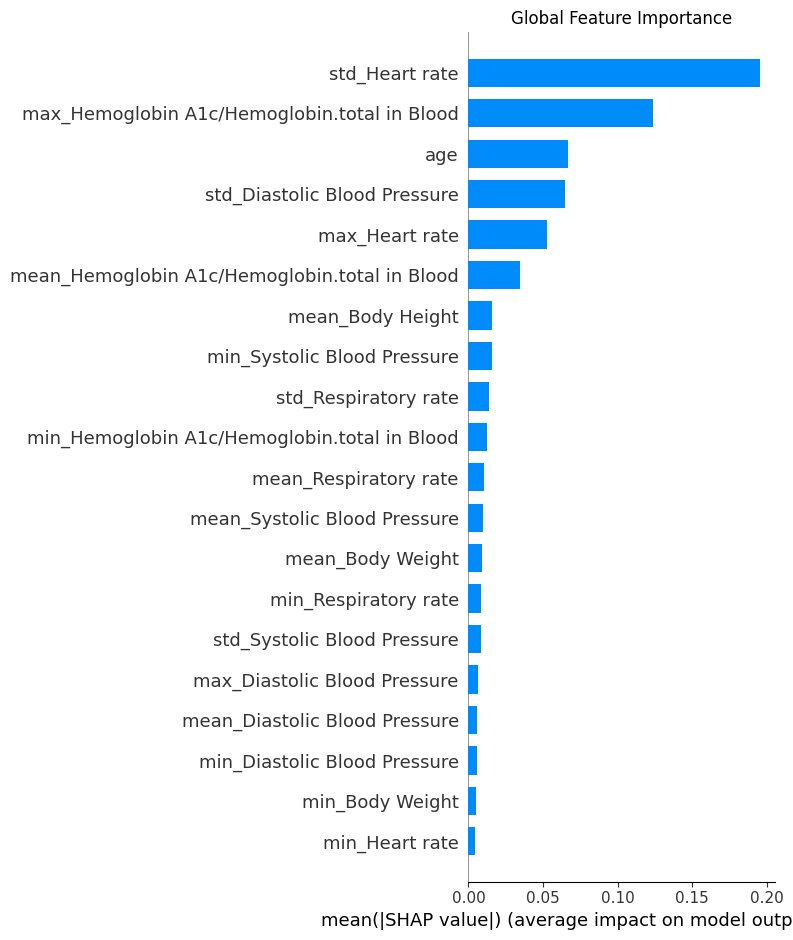


Searching for a high-risk patient to explain...
Generating local explanation for patient at test set index: 15


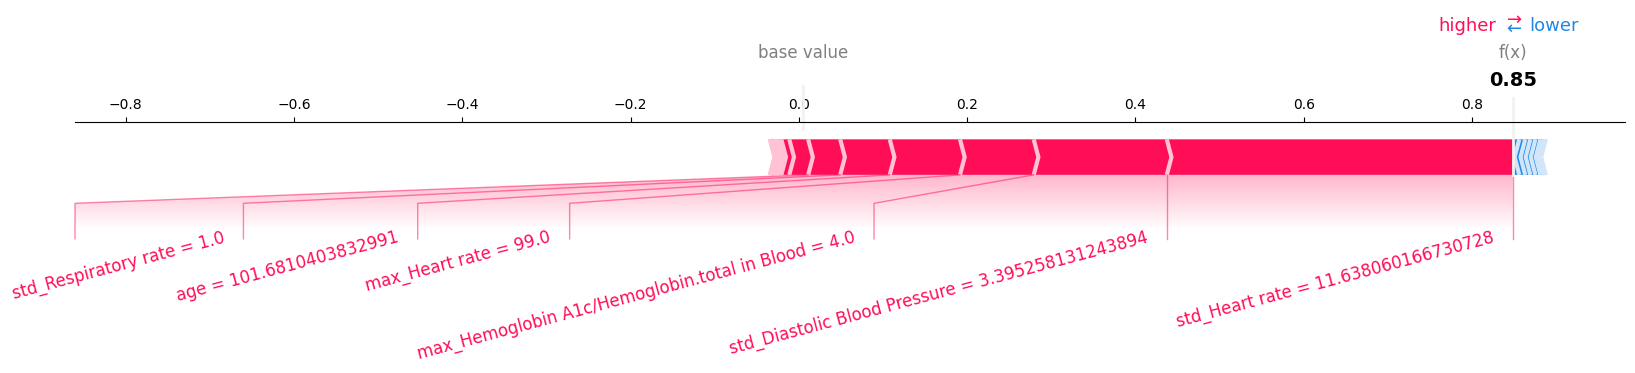

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

print("Creating SHAP explainer and calculating values...")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
print("SHAP calculations complete.")

print("\nGenerating global feature importance plot...")
# biggest impacting prediction features
plt.title("Global Feature Importance")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

print("\nSearching for a high-risk patient to explain...")

try:
    # Find the index of the first patient where the true label was 1 and the predicted label was 1
    high_risk_patient_index = np.where((y_test == 1) & (y_pred_class_best == 1))[0][0]

    print(f"Generating local explanation for patient at test set index: {high_risk_patient_index}")
    
    shap.force_plot(
        explainer.expected_value,
        shap_values[high_risk_patient_index, :],
        X_test.iloc[high_risk_patient_index, :],
        matplotlib=True,
        show=True,
        text_rotation=15
    )
except IndexError:
    print("Could not find a correctly identified high-risk patient in the test set to explain.")
    print("This can happen by chance. The global plot is still the most important result.")

In [ ]:
import matplotlib.pyplot as plt

# 1. save csv file
print("Saving app_data.csv...")

app_df = final_df.sample(n=10000, random_state=42) 
app_df.to_csv("app_data.csv", index=False) 
print("...Done.")

# 2. re-create and save the Global SHAP plot
print("Saving shap_global.png...")
plt.title("Global Feature Importance")
# Use the existing shap_values and X_test variables
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False) 
plt.savefig('shap_global.png', bbox_inches='tight')
plt.clf() 
print("...Done.")

# 3. re-create and save the Local SHAP plot
print("Saving shap_local_example.png...")
try:
    # Use the existing variables to find the patient index again
    high_risk_patient_index = np.where((y_test == 1) & (y_pred_class_best == 1))[0][0]
    
    # Create the plot using existing variables
    shap.force_plot(
        explainer.expected_value,
        shap_values[high_risk_patient_index, :],
        X_test.iloc[high_risk_patient_index, :],
        matplotlib=True,
        show=False,
        text_rotation=15
    )
    plt.savefig('shap_local_example.png', bbox_inches='tight')
    plt.clf() 
    print("...Done.")
except IndexError:
    print("Could not generate local plot in this run.")

Saving app_data.csv...
...Done.
Saving shap_global.png...
...Done.
Saving shap_local_example.png...
...Done.
